<a href="https://colab.research.google.com/github/Mombinjenga/Potato-Disease-Detector/blob/main/Potato_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()
import zipfile

with zipfile.ZipFile("potato-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")



Saving potato-dataset.zip to potato-dataset.zip


In [3]:
# import libraries

import os  # for navigating folders and file paths
import numpy as np  # for working with numbers and arrays
import matplotlib.pyplot as plt  # for plotting graphs
import seaborn as sns  # for nicer looking plots
import warnings
warnings.filterwarnings('ignore')  # hide unnecessary warnings

import tensorflow as tf  # main deep learning framework
from tensorflow import keras  # high level API to build models easily
from tensorflow.keras import layers  # building blocks of our neural network
from tensorflow.keras.applications import EfficientNetB3  # our pretrained model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # loads and augments images
from tensorflow.keras.callbacks import (
    EarlyStopping,     # stops training if model stops improving
    ModelCheckpoint,   # saves the best model during training
    ReduceLROnPlateau  # reduces learning rate when model plateaus
)

from sklearn.metrics import classification_report, confusion_matrix  # for evaluation
from sklearn.utils.class_weight import compute_class_weight  # handles imbalanced classes

# check setup
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os

# path where the dataset was extracted
DATASET_PATH = '/content/dataset'

# loopng through the dataset folder and print each class folder and image count
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"{folder}: {num_images} images")

PlantVillage: 3 images


In [5]:
import os

DATASET_PATH = '/content/dataset'

# print full folder structure
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = '  ' * level
    print(f"{indent}{os.path.basename(root)}/")
    for file in files[:2]:
        print(f"{indent}  - {file}")

dataset/
  PlantVillage/
    Potato___Early_blight/
      - d44a363d-c186-416e-8fad-1a456699bba2___RS_Early.B 7229.JPG
      - 29386668-721c-4359-99a6-734f1a4b096b___RS_Early.B 8362.JPG
    Potato___Late_blight/
      - 8c3c1c3f-5cf0-4daa-9267-243cf1b47927___RS_LB 5005.JPG
      - 01a8cc9f-074a-4866-87c8-bb5a9e3895b4___RS_LB 2968.JPG
    Potato___healthy/
      - 9b5be0c5-7d7e-493d-88ba-c721c85f73ca___RS_HL 5405.JPG
      - 00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG


In [6]:
# update dataset path to point to the correct folder
DATASET_PATH = '/content/dataset/PlantVillage'

# verify by printing each class and image count
for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"{folder}: {num_images} images")

Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images


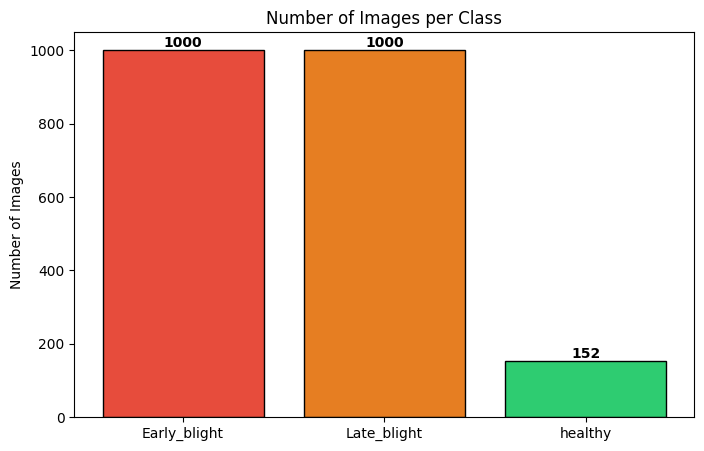

In [7]:
# Class Distribution Chart
import matplotlib.pyplot as plt

# store class names and image counts
class_names = []
class_counts = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        class_names.append(folder.replace('Potato___', ''))  # shorten the name
        class_counts.append(len(os.listdir(folder_path)))

# plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, class_counts, color=['#e74c3c', '#e67e22', '#2ecc71'], edgecolor='black')

# add count on top of each bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', fontweight='bold')

plt.title('Number of Images per Class')
plt.ylabel('Number of Images')
plt.show()

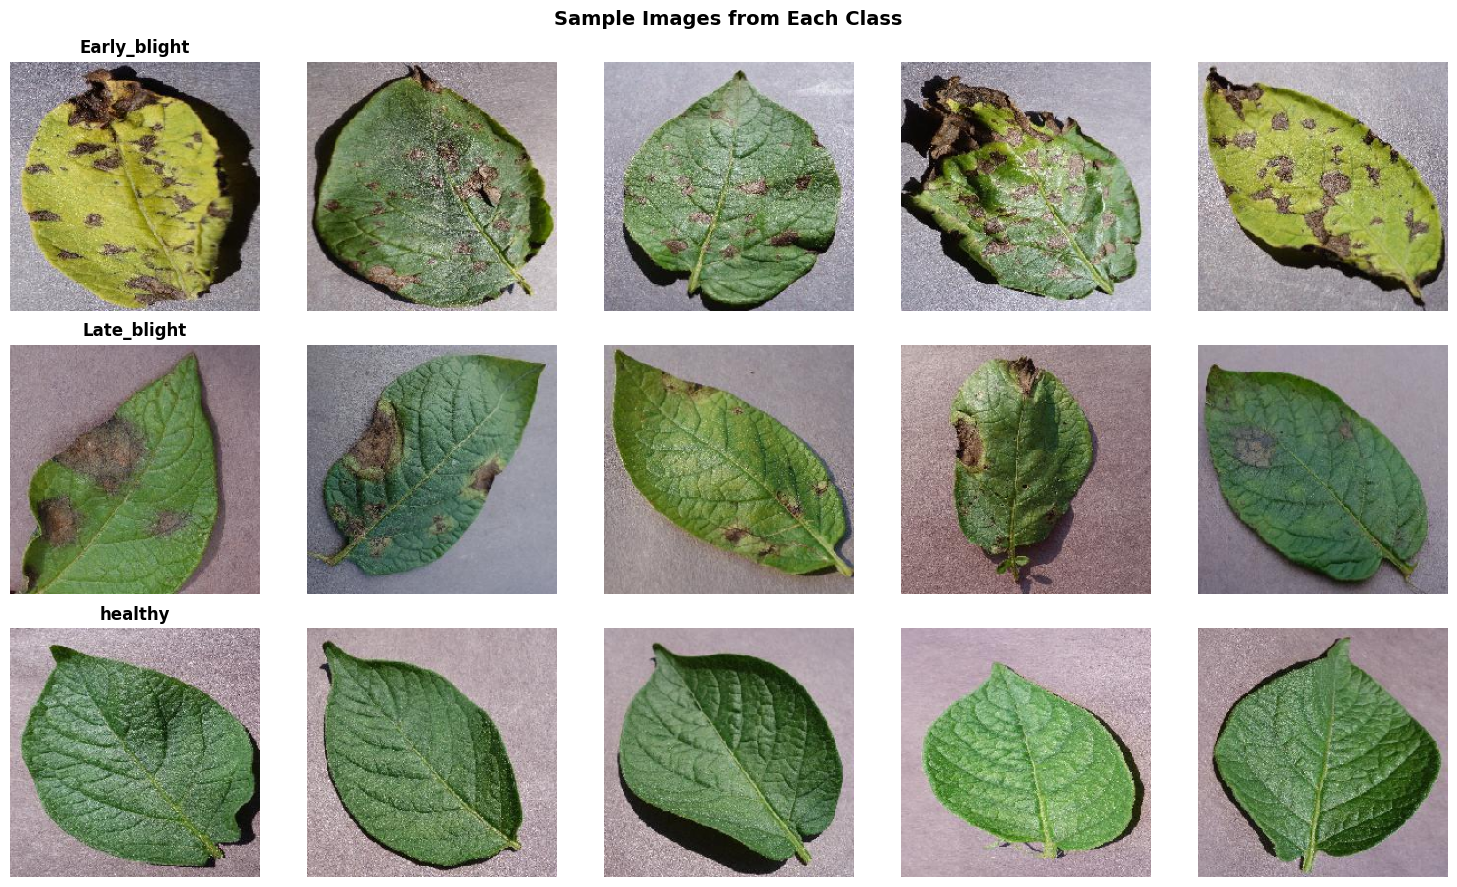

In [8]:
# Sample Images from Each Class
import random
from tensorflow.keras.preprocessing.image import load_img

fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows (classes), 5 columns (samples)
fig.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold')

for row, folder in enumerate(sorted(os.listdir(DATASET_PATH))):
    folder_path = os.path.join(DATASET_PATH, folder)
    if not os.path.isdir(folder_path):
        continue

    # pick 5 random images from each class
    sample_images = random.sample(os.listdir(folder_path), 5)

    for col, img_name in enumerate(sample_images):
        img = load_img(os.path.join(folder_path, img_name), target_size=(224, 224))
        axes[row][col].imshow(img)
        axes[row][col].axis('off')
        if col == 0:  # only label the first column
            axes[row][col].set_title(folder.replace('Potato___', ''), fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Preprocessing and splitting the Dataset
# image settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalize pixels to 0-1
    validation_split=0.2,   # 80% train, 20% validation
    rotation_range=30,       # randomly rotate images
    width_shift_range=0.2,   # randomly shift horizontally
    height_shift_range=0.2,  # randomly shift vertically
    zoom_range=0.25,         # randomly zoom in/out
    horizontal_flip=True,    # randomly flip images
    fill_mode='nearest'      # fill any empty pixels after transformations
)

# validation generator — no augmentation, only normalize
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# load training images from folders
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # 3 classes so we use categorical
    subset='training',
    seed=42,
    shuffle=True
)

# load validation images from folders
val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False  # don't shuffle validation so results are consistent
)

print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {val_generator.n}")
print(f"Class mapping: {train_generator.class_indices}")

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.
Training samples: 1722
Validation samples: 430
Class mapping: {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


In [10]:
# compute class weights to handle imbalanced dataset

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# get the class labels from the training data
labels = train_generator.classes

# automatically calculate weights — minority classes get higher weight
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# convert to dictionary format keras expects
class_weights = dict(enumerate(class_weights_array))

# print the weights
for class_name, idx in train_generator.class_indices.items():
    print(f"{class_name.replace('Potato___', '')}: weight = {class_weights[idx]:.4f}")

Early_blight: weight = 0.7175
Late_blight: weight = 0.7175
healthy: weight = 4.7049


In [11]:
# build the potato disease detection model

NUM_CLASSES = 3

# load EfficientNetB3 pretrained on ImageNet, without the top classification layer
base_model = EfficientNetB3(
    include_top=False,       # remove the original classification head
    weights='imagenet',      # use pretrained weights
    input_shape=(224, 224, 3)
)

# freeze the base model — we don't want to change its pretrained weights yet
base_model.trainable = False

# build our custom layers on top of the base model
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)      # summarize features into a single vector
x = layers.BatchNormalization()(x)           # normalize to stabilize training
x = layers.Dense(256, activation='relu')(x) # learn disease specific features
x = layers.Dropout(0.4)(x)                  # prevent overfitting
x = layers.Dense(128, activation='relu')(x) # refine features further
x = layers.Dropout(0.3)(x)                  # prevent overfitting
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)  # output 3 class probabilities

model = keras.Model(inputs, outputs)

# compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # adam is a reliable optimizer
    loss='categorical_crossentropy',  # standard loss for multi-class problems
    metrics=['accuracy']
)

print("Model built successfully!")
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,216,434 (42.79 MB)

 Trainable params: 429,827 (1.64 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [16]:
# potato disease detection model - rebuild model from scratch

tf.keras.backend.clear_session()

In [17]:
# confirm model is ready
print("Model rebuilt successfully!")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights])}")

Model rebuilt successfully!
Trainable params: 429827


In [18]:
# potato disease detection model - phase 1 training

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model_phase1.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

history_phase1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print(f"Best val accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 448ms/step - accuracy: 0.5974 - loss: 0.8648 - val_accuracy: 0.9233 - val_loss: 0.3869 - learning_rate: 5.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 427ms/step - accuracy: 0.8628 - loss: 0.2935 - val_accuracy: 0.9419 - val_loss: 0.2285 - learning_rate: 5.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.9282 - loss: 0.1852 - val_accuracy: 0.9512 - val_loss: 0.1708 - learning_rate: 5.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.9127 - loss: 0.2262 - val_accuracy: 0.9372 - val_loss: 0.1697 - learning_rate: 5.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.9254 - loss: 0.1778 - val_accuracy: 0.9581 - val_loss: 0.1037 - learning_rate: 5.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 393ms/step - accuracy: 0.9441 - loss: 0.1206 - val_accuracy: 0.9395 - val_loss: 0.1826 - learning_rate: 5.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 426ms/step - acc

In [19]:
# potato disease detection model - phase 2 fine tuning

# unfreeze the base model
base_model.trainable = True

# freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# recompile with a much lower learning rate to avoid destroying pretrained weights
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_ft = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model_finetuned.keras',
        monitor='val_accuracy',
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-8
    )
]

history_phase2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks_ft,
    verbose=1
)

print(f"Best val accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8957 - loss: 0.3337 - val_accuracy: 0.9279 - val_loss: 0.2133 - learning_rate: 1.0000e-05
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.9145 - loss: 0.2555 - val_accuracy: 0.9233 - val_loss: 0.2266 - learning_rate: 1.0000e-05
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.9304 - loss: 0.1982 - val_accuracy: 0.9256 - val_loss: 0.2020 - learning_rate: 1.0000e-05
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.9160 - loss: 0.2032 - val_accuracy: 0.9326 - val_loss: 0.1883 - learning_rate: 1.0000e-05
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 422ms/step - accuracy: 0.9364 - loss: 0.1647 - val_accuracy: 0.9442 - val_loss: 0.1693 - learning_rate: 1.0000e-05
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 439ms/step - accuracy: 0.9293 - loss: 0.1889 - val_accuracy: 0.9465 - val_loss: 0.1557 - learning_rate: 1.0000e-05
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 431ms/step - accur

In [ ]:
# potato disease detection model - plot training curves

def plot_history(h1, h2):
    # combine both phases
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    epochs = range(1, len(acc) + 1)
    split = len(h1.history['accuracy'])  # where phase 2 starts

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # accuracy plot
    ax1.plot(epochs, acc, 'b-', label='Train Accuracy')
    ax1.plot(epochs, val_acc, 'r-', label='Val Accuracy')
    ax1.axvline(x=split, color='gray', linestyle='--', label='Fine tuning starts')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # loss plot
    ax2.plot(epochs, loss, 'b-', label='Train Loss')
    ax2.plot(epochs, val_loss, 'r-', label='Val Loss')
    ax2.axvline(x=split, color='gray', linestyle='--', label='Fine tuning starts')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()